In [107]:
import pandas as pd
import numpy as np
import nudenet as nn
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [3]:
#####################
### I. FIRST LOOK ###
#####################

# Try out nude detector
detector = nn.NudeDetector()
result1 = detector.detect('../../data/zielordner_nude_painting/8418-nude-1493.jpg')
print(result1)
print(type(result1))
print(result1[0])

# --> detect() returns a list of dictionaries, one for each sensitive body part. 
# In each dictionary, we find the name of the class, a detection score and a boundary box around the body part 

[{'class': 'BELLY_EXPOSED', 'score': 0.7100557088851929, 'box': [107, 209, 86, 72]}, {'class': 'FACE_FEMALE', 'score': 0.6270657777786255, 'box': [138, 42, 58, 51]}, {'class': 'FEET_COVERED', 'score': 0.5888346433639526, 'box': [123, 516, 47, 72]}, {'class': 'FEET_COVERED', 'score': 0.5594183802604675, 'box': [165, 512, 54, 77]}, {'class': 'FEMALE_BREAST_EXPOSED', 'score': 0.50235915184021, 'box': [152, 147, 54, 51]}, {'class': 'FEMALE_GENITALIA_EXPOSED', 'score': 0.3315161168575287, 'box': [131, 288, 45, 38]}]
<class 'list'>
{'class': 'BELLY_EXPOSED', 'score': 0.7100557088851929, 'box': [107, 209, 86, 72]}


In [63]:
#####################################
### II. DETECT ALL NUDE PAINTINGS ###
#####################################
df_nude = pd.read_csv('../../data/filtered_genres_nude_painting.csv')
default_path = '../../data/zielordner_nude_painting/'
result_list = []

# Use nudenet detector on all nude paintings
for filename in df_nude.file_name:
    path = default_path + filename
    result = detector.detect(path)
    result_list.append(result)

# Make new dataframe with original metadata + detections as new column
df_detections = df_nude
df_detections = df_detections.assign(detections = result_list)
df_detections

,artist,style,genre,movement,tags,url,img,file_name,detections
0,Lo Scheggia,Early Renaissance,"genre painting,nude painting (nu)",Early Renaissance,"['Human', 'Muscle', 'Humanbody']",https://www.wikiart.org/en/lo-scheggia/desco-d...,https://uploads0.wikiart.org/00218/images/lo-s...,3338-lo-scheggia-desco-da-parto-con-due-fanciu...,"[{'class': 'FEET_EXPOSED', 'score': 0.75175225..."
1,Lo Scheggia,Early Renaissance,nude painting (nu),Early Renaissance,"['Arm', 'Human']",https://www.wikiart.org/en/lo-scheggia/reclini...,https://uploads7.wikiart.org/00218/images/lo-s...,3341-lo-scheggia-reclining-youth-wga20987.jpg,[]
2,Gentile Bellini,High Renaissance,nude painting (nu),Early Renaissance,"['Mythology', 'Beauty']",https://www.wikiart.org/en/gentile-bellini/jun...,https://uploads5.wikiart.org/00290/images/gent...,3689-giovanni-bellini-giovane-donna-nuda-allo-...,"[{'class': 'FACE_FEMALE', 'score': 0.813402593..."
3,Antonio del Pollaiolo,Early Renaissance,nude painting (nu),Early Renaissance,"['History', 'Ancienthistory', 'Stonecarving']",https://www.wikiart.org/en/antonio-del-pollaio...,https://uploads1.wikiart.org/00247/images/anto...,3699-antonio-del-pollaiolo-nudi-danzanti.jpg,[]
4,Antonio del Pollaiolo,Early Renaissance,"nude painting (nu),mythological painting",Early Renaissance,"['Human', 'Organism', 'Sketch']",https://www.wikiart.org/en/antonio-del-pollaio...,https://uploads4.wikiart.org/00245/images/anto...,3709-battle-of-the-naked-men-metny.jpg,[]
...,...,...,...,...,...,...,...,...,...
4186,Alfred Freddy Krupa,Symbolism,"nude painting (nu),sketch and study",New Ink Art,NaN,https://www.wikiart.org/en/alfred-freddy-krupa...,https://uploads4.wikiart.org/00373/images/alfr...,252903-img-20211228-213013.jpg,[]
4187,Alfred Freddy Krupa,New Ink Painting,"symbolic painting,nude painting (nu)",New Ink Art,NaN,https://www.wikiart.org/en/alfred-freddy-krupa...,https://uploads4.wikiart.org/00373/images/alfr...,252904-img-20211228-212456.jpg,[]
4188,Alfred Freddy Krupa,Figurative Expressionism,nude painting (nu),New Ink Art,"['Graphicdesign', 'Line']",https://www.wikiart.org/en/alfred-freddy-krupa...,https://uploads8.wikiart.org/00193/images/alfr...,252908-1-1.jpg,[]
4189,Alfred Freddy Krupa,New Realism,nude painting (nu),New Ink Art,['Paperproduct'],https://www.wikiart.org/en/alfred-freddy-krupa...,https://uploads6.wikiart.org/00192/images/alfr...,252924-2.jpg,[]


In [64]:
# set all empty lists to NA and count
df_detections.detections = df_detections.detections.apply(lambda y: pd.NA if len(y)==0 else y)
df_detections.count()
# --> detected something in 2700 out of 4191 images

artist        4191
style         4191
genre         4191
movement      4191
tags          2962
url           4191
img           4191
file_name     4191
detections    2700
dtype: int64

In [66]:
#################################
### III. DEFINE NUDE PAINTING ###
#################################

'''Define, what counts as nude paintings?
--> ANUS_EXPOSED, BUTTOCKS_EXPOSED, FEMALE_BREAST_EXPOSED, FEMALE_GENITALIA_EXPOSED, MALE_GENITALIA_EXPOSED
--> plus FEMALE_GENITALIA_COVERED & MALE_GENITALIA_COVERED to find detect older paintings (where genitalia is typically covered with leafs, hands etc.)

Then make new column based on this categorization (nude: yes/no):
'''

relevant_nudity_classes = ['ANUS_EXPOSED', 'BUTTOCKS_EXPOSED', 'FEMALE_BREAST_EXPOSED', 'FEMALE_GENITALIA_EXPOSED', 
                           'MALE_GENITALIA_EXPOSED', 'FEMALE_GENITALIA_COVERED', 'MALE_GENITALIA_COVERED']

# new column "nude"
df_detections['nude'] = False

# The "nude" classes are saved as values in the dictionaries (one dictionary per class)
# Iterate over rows, dictionaries and their values to find them
for ind in df_detections.index:
    detection = df_detections['detections'][ind]

    if isinstance(detection, list): # only loop through, if not NA
        for dictionary in detection:
            for nudity_class in dictionary.values():
                if nudity_class in relevant_nudity_classes:
                    df_detections['nude'][ind] = True

df_detections.nude.value_counts()

# 1759 out of 4191 detected as nude!

/var/folders/yx/9d3m_ryd2vn67r2brqf_d9cc0000gp/T/ipykernel_38090/4164534081.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_detections['nude'][ind] = True
/var/folders/yx/9d3m_ryd2vn67r2brqf_d9cc0000gp/T/ipykernel_38090/4164534081.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_detections['nude'][ind] = True
/var/folders/yx/9d3m_ryd2vn67r2brqf_d9cc0000gp/T/ipykernel_38090/4164534081.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

nude
False    2432
True     1759
Name: count, dtype: int64

In [ ]:
##################################
### IV. DEFINE DETECTED GENDER ###
##############################

'''Define gender: 
- "female", if one of these categories is present:
--> FACE_FEMALE, FEMALE_BREAST_EXPOSED, FEMALE_BREAST_COVERED, FEMALE_GENITALIA_EXPOSED, FEMALE_GENITALIA_COVERED

- "male", if one of these categories is present:
--> FACE_MALE, MALE_BREAST_EXPOSED, MALE_BREAST_COVERED, MALE_GENITALIA_EXPOSED, MALE_GENITALIA_COVERED

- "unknown", if mixed result OR no information

Then make new column based on this categorization (gender: female/male/unknown):
'''

female_classes = ['FACE_FEMALE', 'FEMALE_BREAST_EXPOSED', 'FEMALE_BREAST_COVERED', 'FEMALE_GENITALIA_EXPOSED', 'FEMALE_GENITALIA_COVERED']
male_classes = ['FACE_MALE', 'MALE_BREAST_EXPOSED', 'MALE_BREAST_COVERED', 'MALE_GENITALIA_EXPOSED', 'MALE_GENITALIA_COVERED']

# new column "gender"
df_detections['gender'] = 'unknown'

# The "gender" classes are saved as values in the dictionaries (one dictionary per class)
# Iterate over rows, dictionaries and their values to find them
for ind in df_detections.index:
    detection = df_detections['detections'][ind]

    # set to unknown in the beginning
    male_flag = False
    female_flag = False

    if isinstance(detection, list): # only loop through, if not NA
        for dictionary in detection:
            for nudity_class in dictionary.values():
                if nudity_class in female_classes:
                    female_flag = True
                elif nudity_class in male_classes:
                    male_flag = True
        
        # if mixed result, remain "unknown"
        if female_flag  and not male_flag:
            df_detections['gender'][ind] = 'female'
        elif male_flag and not female_flag:
            df_detections['gender'][ind] = 'male'

df_detections.gender.value_counts()

In [201]:
# Save new csv with "gender" and "nude" column
#df_detections.to_csv('nude_paintings_detections.csv')

In [148]:
######################################################
### V. ANALYSIS OF ART STYLES --> NUDITY DETECTION ###
######################################################

# Calculate frequencies of art styles
freq_styles = ['Expressionism', 'Impressionism', 'Post-Impressionism', 'Academicism', 'Realism', 'Art Nouveau (Modern)', 
               'Surrealism', 'Kitsch', 'Cubism', 'Symbolism', 'Contemporary Realism', 'Fauvism', 'Romanticism'] # these are the most common ones
df_plot = df_detections.loc[df_detections['style'].isin(freq_styles)]
df_plot['style'].value_counts(normalize=True)

style
Expressionism           0.282510
Impressionism           0.146294
Post-Impressionism      0.096554
Academicism             0.067620
Realism                 0.060793
Art Nouveau (Modern)    0.051040
Surrealism              0.051040
Kitsch                  0.050065
Cubism                  0.044538
Symbolism               0.041612
Contemporary Realism    0.037711
Fauvism                 0.035761
Romanticism             0.034460
Name: proportion, dtype: float64

In [199]:
# Calculate proportions of nudity detection (for each frequent style)
table = pd.crosstab(index=df_plot['style'], columns=df_plot['nude'], normalize='index')
table#.plot.bar(stacked=True)

nude,False,True
style,,
Academicism,0.403846,0.596154
Art Nouveau (Modern),0.694268,0.305732
Contemporary Realism,0.491379,0.508621
Cubism,0.795620,0.204380
Expressionism,0.665132,0.334868
Fauvism,0.545455,0.454545
Impressionism,0.564444,0.435556
Kitsch,0.454545,0.545455
Post-Impressionism,0.498316,0.501684


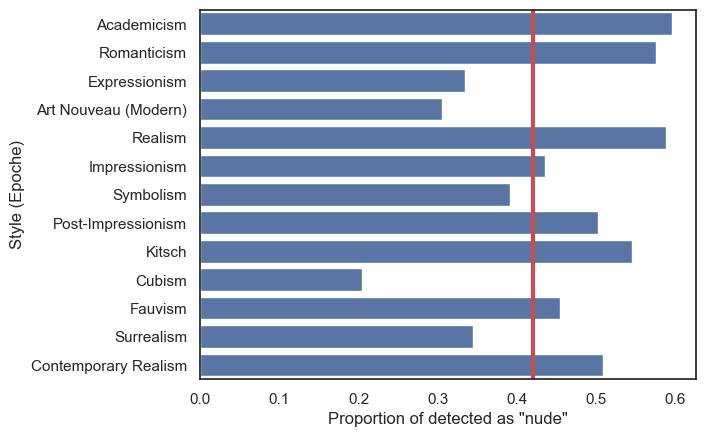

In [197]:
# Make Plot with seaborn
plot = (
    sns.barplot(data = df_plot, x = 'nude', y = 'style', 
                errorbar = None, orient = 'y')
    )
plot.set(xlabel = 'Proportion of detected as "nude"', ylabel = 'Style (Epoche)')

plot.axvline(x = 0.4197, color = 'r', linewidth = 3) # Line shows general proportion: 1759 / 4191 = 41.97%

# --> Above average (of the frequent styles) are: Academicism, Romanticism, Realism, Impressionism, 
# Post-Impressionism, Kitsch, Fauvism, Contemporary Realism

In [77]:
####################################################################
### LOGISTIC REGRESSION WITH NUDITY DETECTION AS OUTPUT VARIABLE ###
####################################################################

# Categorical input data has to be dummy-coded, first
dfanalysis =  df_detections[['artist', 'style', 'genre', 'movement', 'nude']]
artist = pd.get_dummies(dfanalysis['artist'], drop_first=True)
style = pd.get_dummies(dfanalysis['style'], drop_first=True)
genre = pd.get_dummies(dfanalysis['genre'], drop_first=True)
movement = pd.get_dummies(dfanalysis['movement'], drop_first=True)

# Drop old columns
dfanalysis.drop(['artist', 'style', 'genre', 'movement'], axis = 1, inplace = True)

# Add new dummy columns to "nude" column
dfanalysis = pd.concat([dfanalysis, artist, style, genre, movement], axis = 1)


/var/folders/yx/9d3m_ryd2vn67r2brqf_d9cc0000gp/T/ipykernel_38090/4240864591.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfanalysis.drop(['artist', 'style', 'genre', 'movement'], axis = 1, inplace = True)


In [105]:
# Initialise logistic regression (with sklearn package)
logreg = LogisticRegression()

logreg.fit(dfanalysis.loc[ : , dfanalysis.columns != 'nude'], # select all columns x
           dfanalysis.nude)


LogisticRegression()